# packages

In [22]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("pandas")
install("numpy")
install("matplotlib")

# imports

In [3]:
import pandas as pd
import numpy as np
import json
import csv
import os
import matplotlib.pyplot as plt

# Read data variable from csv

In [206]:
df = pd.read_csv(filepath_or_buffer="data/extraction consolidation results_V0_3.csv",sep=";", encoding="latin-1")
result = df['Title'].to_list()
result = list(dict.fromkeys(result))
titles = list(df.columns)
metadata = pd.read_csv("./data/search_results.csv", sep=";", encoding="latin-1")
metadata = metadata.drop_duplicates(subset=['Title'])
data = df.merge(metadata, how='left', on='Title')
del metadata
del df
del titles

In [203]:
data.head()

,Title,DT Definition,virtual space,Kritzinger,DT is specific,modeling language,note on modeling language,model type,model processing technique,model usage technique,...,purpose /expected benefit of using models,open challenges,Technological Readiness Level,notes,Use Case,Publication Title,Authors,Publication Year,Document Identifier,Publisher
0,A framework for Model-Driven Engineering of re...,"dynamic virtual model of a system, processor, ...",Model of PT,NaN,NaN,SysML,NaN,structure,Model to Model Transformation,NaN,...,formal specification of information in the for...,NaN,01.Mär,NaN,limited traffic zone access control,Computing,Parri J.; Patara F.; Sampietro S.; Vicario E.,2021.0,Article,Springer
1,A framework for Model-Driven Engineering of re...,NaN,NaN,NaN,NaN,Knowledge base model,contribution of the paper,NaN,Model to Model Transformation,NaN,...,NaN,NaN,NaN,NaN,NaN,Computing,Parri J.; Patara F.; Sampietro S.; Vicario E.,2021.0,Article,Springer
2,A Methodology for Digital Twin Modeling and De...,"""The digital twin (DT) is a virtual representa...",Model of PT,NaN,NaN,AutomationML,NaN,structure,Code Generation,NaN,...,"model the physical device, serving as the virt...",NaN,01.Mär,NaN,refinery automationsystem with four valves,Proceedings of the IEEE,G. N. Schroeder; C. Steinmetz; R. N. Rodrigues...,2021.0,IEEE Journals,IEEE
3,A Methodology for Digital Twin Modeling and De...,NaN,NaN,NaN,NaN,NaN,NaN,structure,Model Interpretation,NaN,...,NaN,NaN,NaN,NaN,NaN,Proceedings of the IEEE,G. N. Schroeder; C. Steinmetz; R. N. Rodrigues...,2021.0,IEEE Journals,IEEE
4,A Novel Methodology to Construct Digital Twin ...,"""a digital twin of a system consists of a set ...",Comprehensive,DS,NaN,Fault Tree,NaN,behavior,Model to Model Transformation,NaN,...,NaN,NaN,01.Mär,NaN,ground station of a spacecraft,Proceedings of the 25th International Conferen...,"Christofi N,Pucel X",2022.0,Conference Paper,ACM


# Data analysis

## What

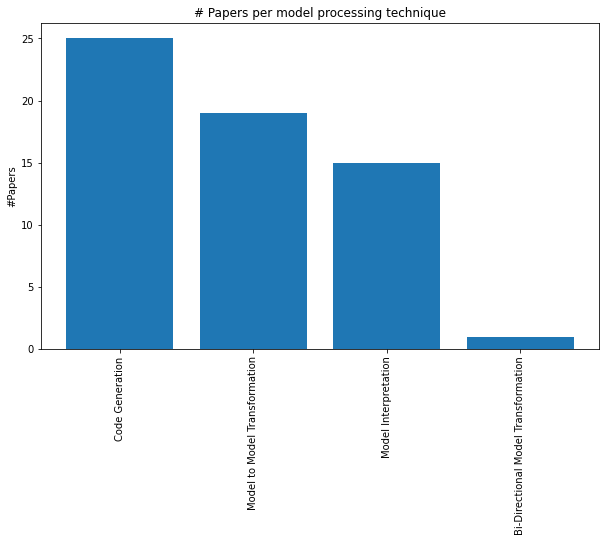

In [200]:
occurrences_df = data["model processing technique"].value_counts().reset_index()
occurrences_df.columns = ['entry', 'count']
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.bar(occurrences_df['entry'], occurrences_df['count'])
plt.ylabel('#Papers')
plt.title('# Papers per model processing technique')
plt.xticks(rotation=90)  # Rotate the x-axis labels if they are too long
plt.show()

In [47]:
data["modeling language"].value_counts()

UML Class Diagram                        4
AutomationML                             3
MontiArc                                 3
SysML                                    2
SysML v2                                 2
BPMN                                     2
Unity 3D simulation model                2
AAS                                      2
MontiGem GUI Model                       1
City GML 3D city model                   1
design of experiment language            1
OPC UA DSL                               1
Tagging Language                         1
MontiArc ADL                             1
tagging language                         1
MontiThings                              1
GUI DSL                                  1
OCL                                      1
cyber-physical spaces                    1
UML Activity Diagram                     1
undefined                                1
Twin Process Model                       1
EMF Meta-Models                          1
Data Model 

C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_12856\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_12856\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_12856\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_12856\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_data['entry'], rotation=90)
C:\Users\Daniel Lehner\AppData\Local\Temp\ipykernel_12856\3755245987.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_dat

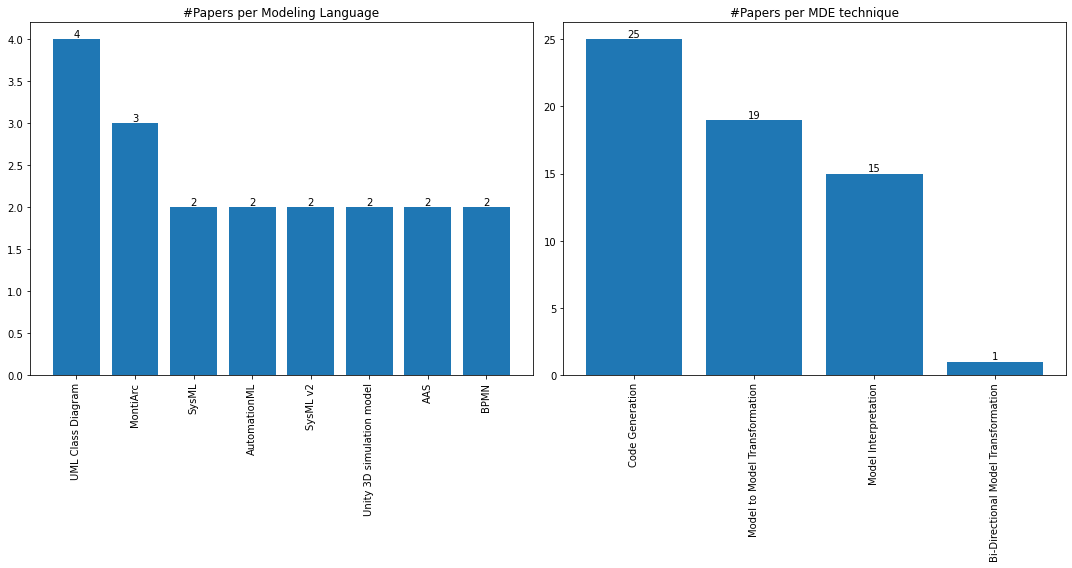

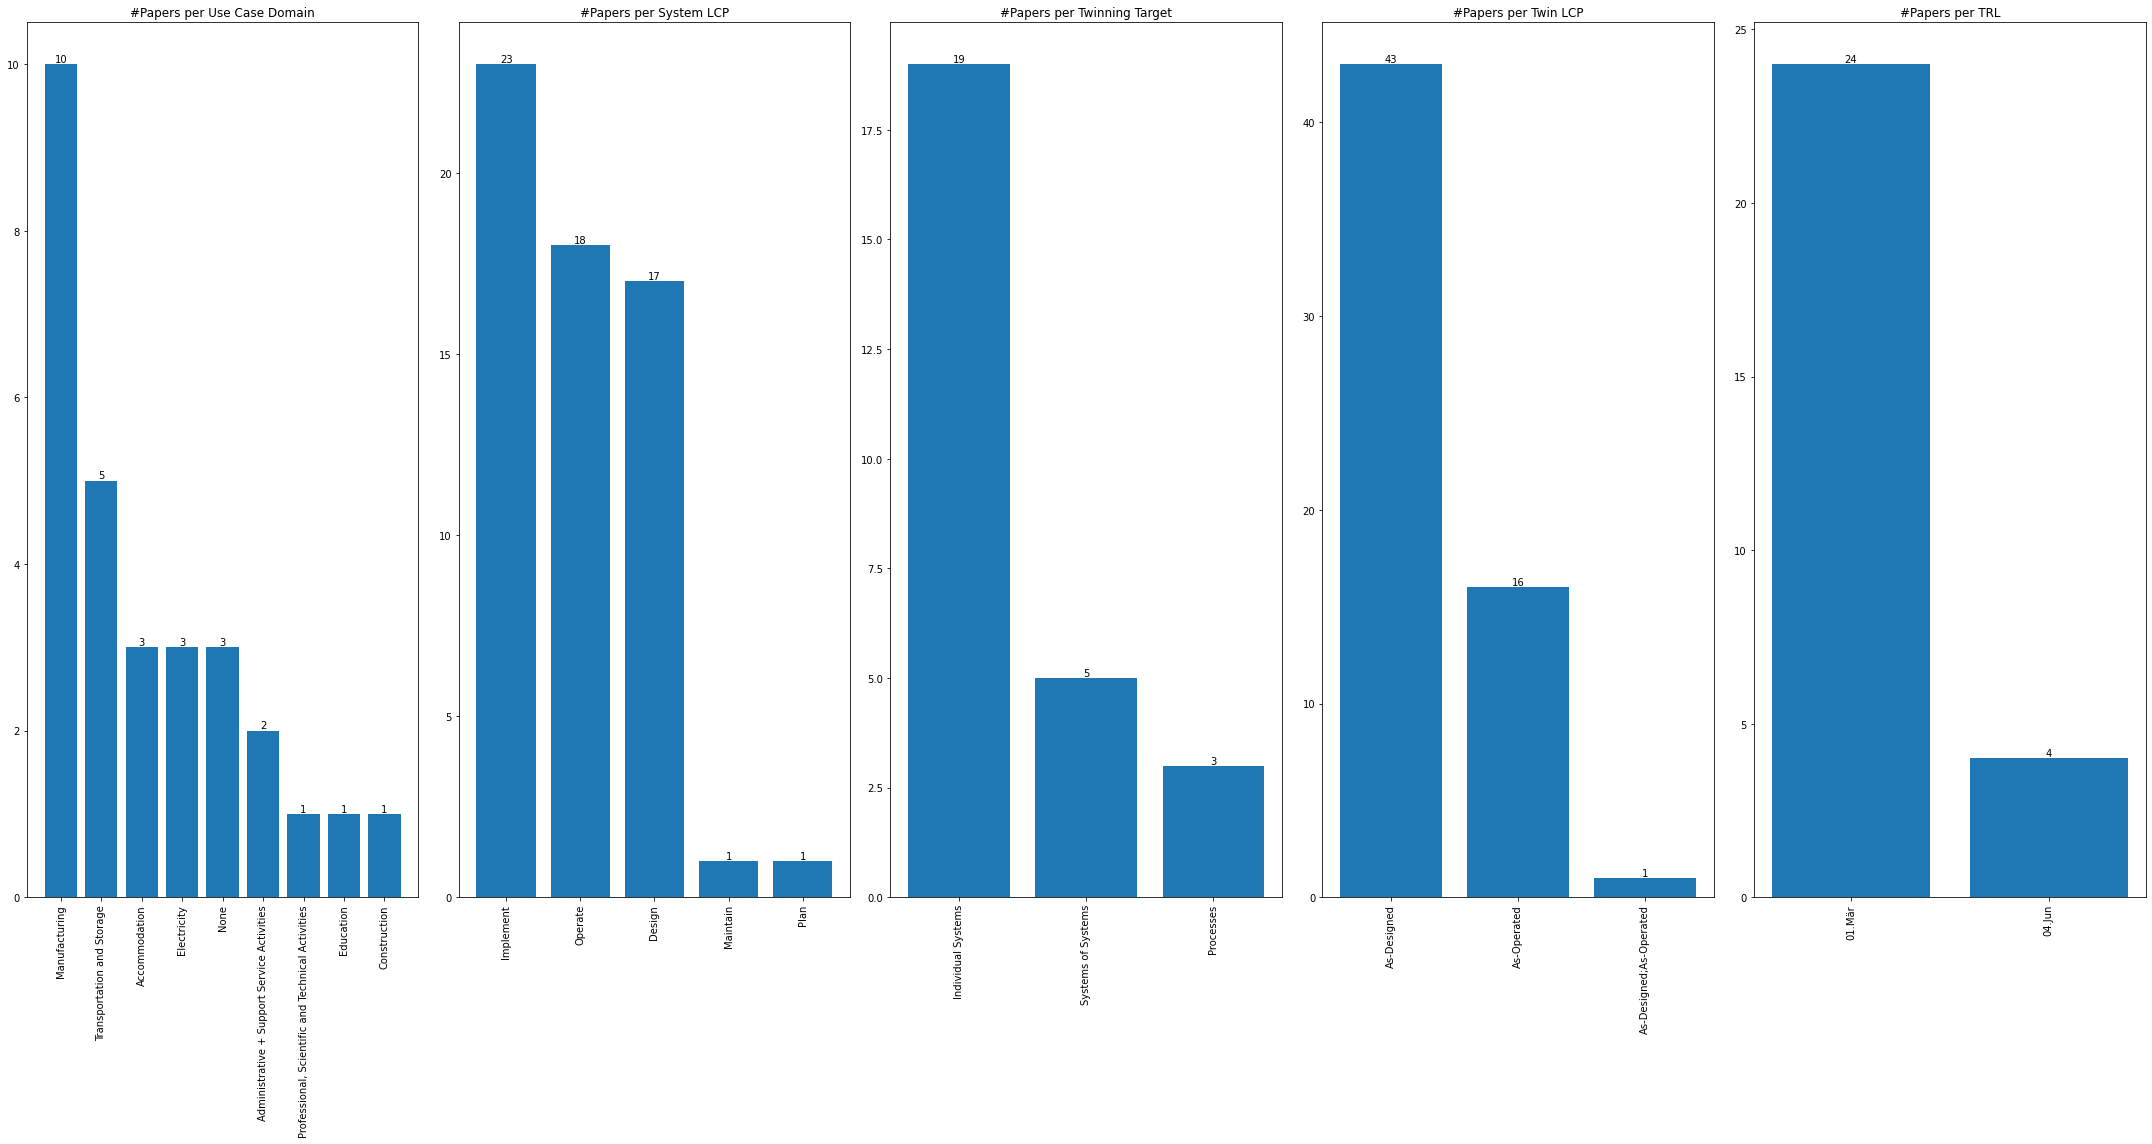

In [207]:
modeling_language = data["modeling language"].value_counts().reset_index()
modeling_language.columns = ['entry', 'count']
modeling_language  = modeling_language[modeling_language['count'] > 1]
mde_technique= data["model processing technique"].value_counts().reset_index()
mde_technique.columns = ['entry', 'count']
use_case_domain = data["use case domain"].value_counts().reset_index()
use_case_domain.columns = ['entry', 'count']
system_lcp = data["system lifecycle phase"].value_counts().reset_index()
system_lcp.columns = ['entry', 'count']
twinning_target = data["twinning target"].value_counts().reset_index()
twinning_target.columns = ['entry', 'count']
twin_lcp= data["twin lifecycle phase"].value_counts().reset_index()
twin_lcp.columns = ['entry', 'count']
trl = data["Technological Readiness Level"].value_counts().reset_index()
trl.columns = ['entry', 'count']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# List of DataFrames
dataframes = [modeling_language, mde_technique]
# Titles for each subplot (modify as needed)
titles = ['#Papers per Modeling Language', '#Papers per MDE technique']

# Loop through the subplots and plot each bar chart
for i, ax in enumerate(axes.flatten()):
    if i < len(dataframes):
        plot_data = dataframes[i]
        ax.bar(plot_data['entry'], plot_data['count'], tick_label=plot_data['count'])  # Replace 'x' and 'y' with the appropriate column names from the DataFrame
        ax.set_title(titles[i])
        ax.set_xticklabels(plot_data['entry'], rotation=90)
        ax.bar_label(ax.containers[0])

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
#plt.show()
plt.savefig("what.jpg")

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 16))

# List of DataFrames
dataframes = [use_case_domain, system_lcp, twinning_target, twin_lcp, trl]
# Titles for each subplot (modify as needed)
titles = ['#Papers per Use Case Domain', '#Papers per System LCP', '#Papers per Twinning Target', '#Papers per Twin LCP', '#Papers per TRL']

# Loop through the subplots and plot each bar chart
for i, ax in enumerate(axes.flatten()):
    if i < len(dataframes):
        plot_data = dataframes[i]
        ax.bar(plot_data['entry'], plot_data['count'])  # Replace 'x' and 'y' with the appropriate column names from the DataFrame
        ax.set_title(titles[i])
        ax.set_xticklabels(plot_data['entry'], rotation=90)
        ax.bar_label(ax.containers[0])

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.savefig("where.jpg")

{'A framework for Model-Driven Engineering of resilient software-controlled systems': {'DT_Definition': 'dynamic virtual model of a system, processor, or service, with data (e.g., sensor data) from physical systems or processes integrated into it.; "Software digital twins representations provide a key abstraction, providing an agile interface on hardware components, capturing operational behaviours of physical assets and processes, also providing refined and interpreted data, to enable diagnoses, predic\x02tive maintenance tasks, process plannings, process optimizations, virtual prototyping, and simulation."', 'modelTrafos': {'0': '{"model type":"structure","model processing technique":"Model to Model Transformation","model usage technique":null,"source":"SysML: BDD","target":"Knowledge Base of software digital twins (Metamodel proposed in Figure 5 of the paper) -> in fact, this is the class diagram of their knowledge base","purpose of MDE application":"reuse information created by rel

## Where

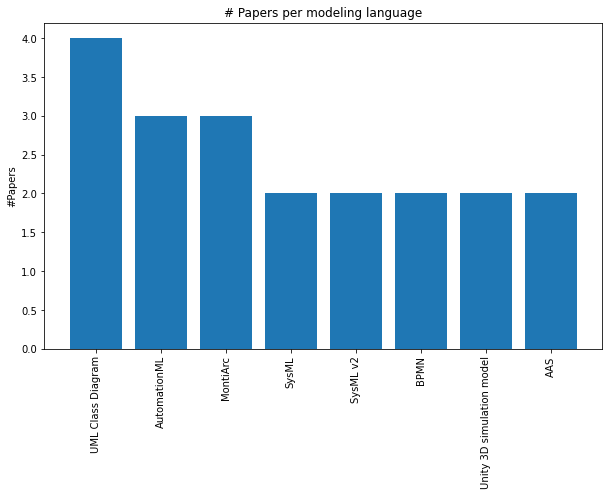

In [24]:
occurrences_df = data["modeling language"].value_counts().reset_index()
occurrences_df.columns = ['entry', 'count']
occurrences_df = occurrences_df[occurrences_df['count'] > 1]
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.bar(occurrences_df['entry'], occurrences_df['count'])
plt.ylabel('#Papers')
plt.title('# Papers per modeling language')
plt.xticks(rotation=90)  # Rotate the x-axis labels if they are too long
plt.show()

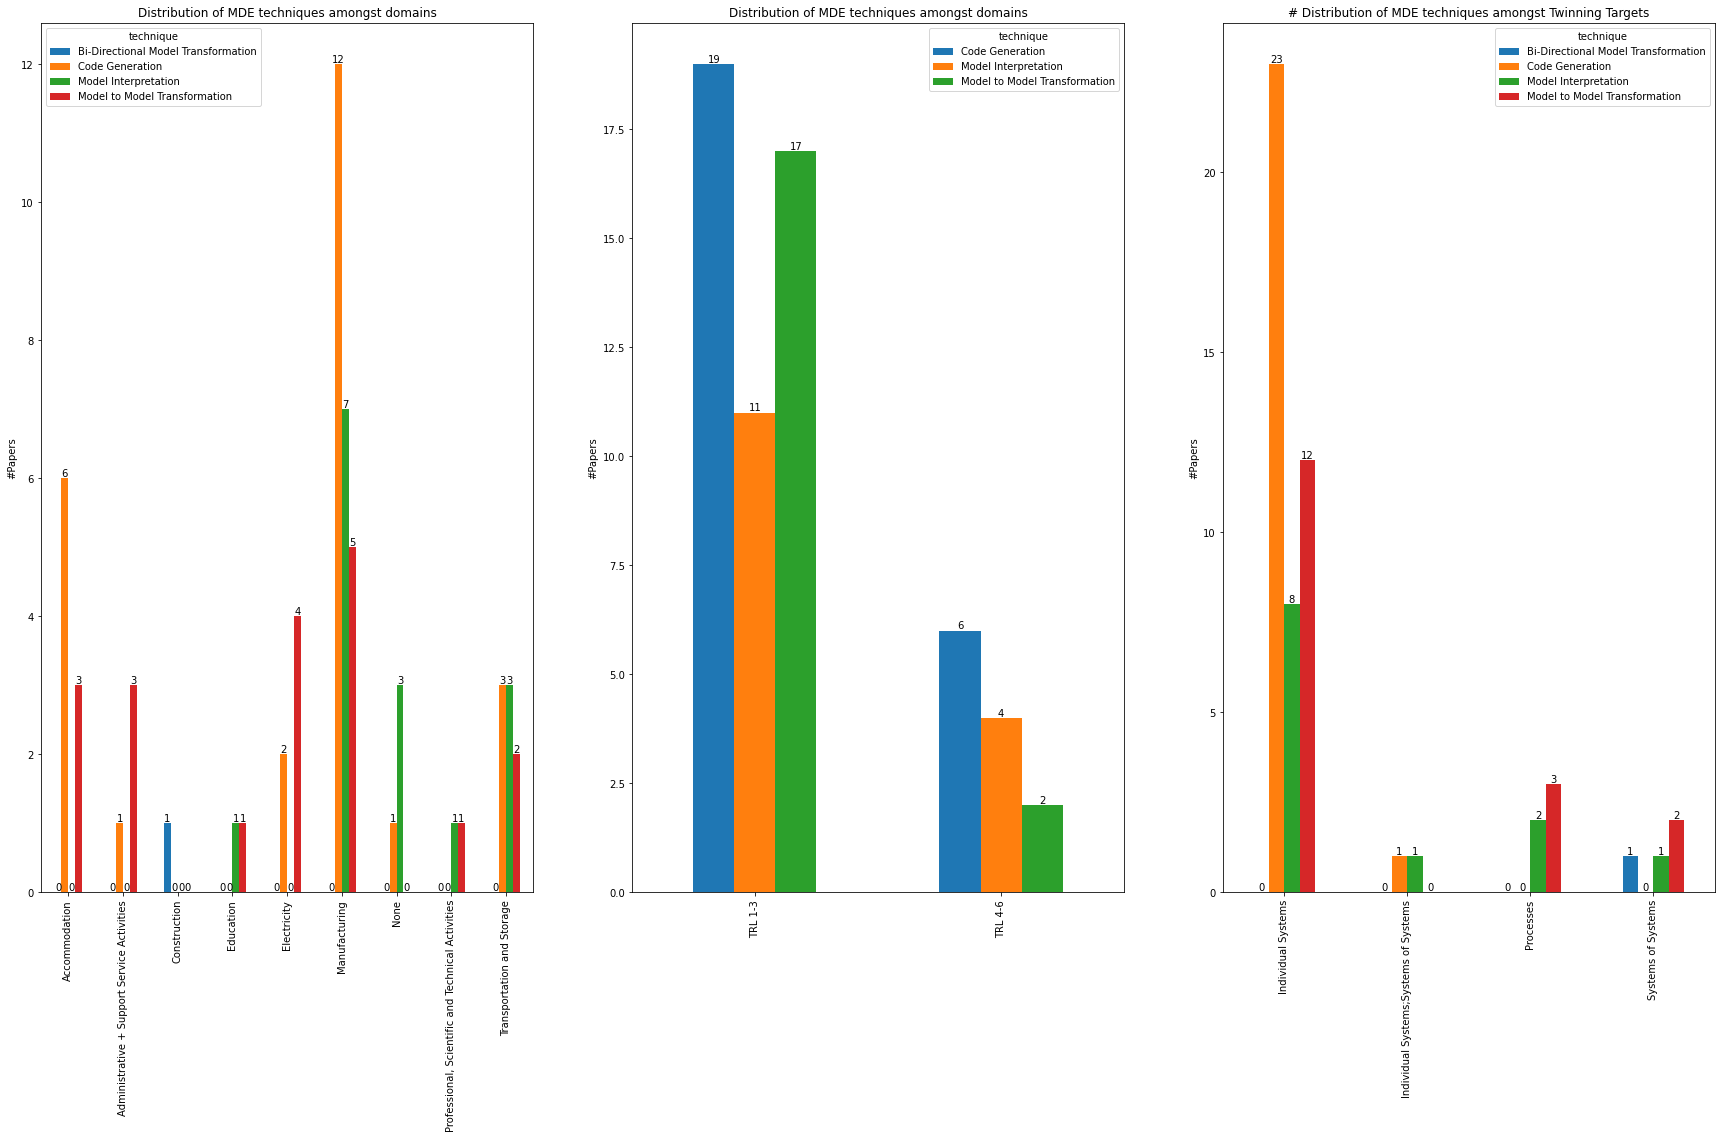

In [221]:
domains_techniques = pd.DataFrame(columns = ['value', 'technique'])
system_lcp_techniques = pd.DataFrame(columns = ['value', 'technique'])
twin_lcp_techniques = pd.DataFrame(columns = ['value', 'technique'])
twinning_target_techniques = pd.DataFrame(columns = ['value', 'technique'])
trl_techniques = pd.DataFrame(columns = ['value', 'technique'])

with open("target/json/data_consolidated_semistructured.json", 'r') as json_file:
    data_semistr = json.load(json_file)
    
mde_techniques = data["model processing technique"].value_counts().index.tolist()
for title, contents in data_semistr.items():
    domain = contents["use case domain"]
    trl = contents["Technological Readiness Level"]
    twinning_target = contents["twinning target"]
    for index, mdeContents in contents["modelTrafos"].items():
        mdeContents = json.loads(mdeContents)
        new_line = pd.DataFrame([{"value": domain, "technique": mdeContents["model processing technique"]}])
        domains_techniques = pd.concat([domains_techniques, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"value": trl, "technique": mdeContents["model processing technique"]}])
        trl_techniques = pd.concat([trl_techniques, new_line], ignore_index=True)
        new_line = pd.DataFrame([{"value": twinning_target, "technique": mdeContents["model processing technique"]}])
        twinning_target_techniques = pd.concat([twinning_target_techniques, new_line], ignore_index=True)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 16))
ax = domains_techniques.groupby(['value','technique']).size().unstack().plot(kind='bar', stacked=False, ax=axes[0], 
                                                                             ylabel="#Papers", title="Distribution of MDE techniques amongst domains", xlabel="")
label_pre = 0
for container in ax.containers:
    ax.bar_label(container)

ax = trl_techniques.groupby(['value','technique']).size().unstack().plot(kind='bar', stacked=False, ax=axes[1],
                                                                         ylabel="#Papers", title="Distribution of MDE techniques amongst domains", xlabel="")
plt.title('# Distribution of MDE techniques amongst Technological Readiness Levels')
for container in ax.containers:
    ax.bar_label(container)
ax = twinning_target_techniques.groupby(['value','technique']).size().unstack().plot(kind='bar', stacked=False, ax=axes[2],
                                                                                     ylabel="#Papers", title="Distribution of MDE techniques amongst domains", xlabel="")
for container in ax.containers:
    ax.bar_label(container)
plt.title('# Distribution of MDE techniques amongst Twinning Targets')
plt.savefig("where_detailed.jpg")